### 110062539 chKoogoo

把上一個版本(2.1)densenet121的pooling='max'改成pooling='avg'

In [1]:
INPUT_SHAPE = (224, 224, 3)
#INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 32
EPOCHS = 35
PATIENCE = 9 # 如果過多少個EPOCHS沒改善就停止訓練
CATGORICAL = 2
LR = 1e-3
LR_FACTOR = 0.5 # new_lr = lr * factor.
LR_PATIENCE = 4 # umber of epochs with no improvement after which learning rate will be reduced
MODEL_NAME = 'imagenet_Densenet121_current'
MODEL_PATH = MODEL_NAME + '.hdf5'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import PIL
import time
import random
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from IPython import display
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from tensorflow import keras
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Input, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

C:\Users\user\anaconda3\envs\DL\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\anaconda3\envs\DL\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\user\anaconda3\envs\DL\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        # set memory limit
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 1024)])

       
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
Virtual devices cannot be modified after being initialized


## Start Try5: Data augmentation:

https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.FancyPCA

https://hackmd.io/@allen108108/SyCsOIkxB

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://keras.io/zh/preprocessing/image/

http://www.tisv.cn/14/

- 單純flip, rotate沒什麼用，像是pixelwise的operation效果顯著（試驗第一個連結的所有function）

- 之後把有用的function全部放在一起訓練

### ImageDataGenerator:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [4]:
x_train = np.load('./dataset/x_train_imagenet_unlearn.npy')
y_train = np.load('./dataset/y_train_imagenet.npy')
x_val = np.load('./dataset/x_val_imagenet.npy')
y_val = np.load('./dataset/y_val_imagenet.npy')
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [5]:
# ohe labels
y_train = tf.one_hot(y_train, 2)
y_val = tf.one_hot(y_val, 2)

In [6]:
print(x_train.shape)
print(y_train.shape)

(2220, 224, 224, 3)
(2220, 2)


In [7]:
checkpoint = ModelCheckpoint(filepath=MODEL_PATH, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', 
                                   factor=LR_FACTOR, 
                                   patience=LR_PATIENCE, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=1.25e-4)
early = EarlyStopping(monitor='val_acc', 
                      mode="auto", 
                      patience=PATIENCE)

callbacks_list = [checkpoint, reduceLROnPlat, early]
#callbacks_list = [checkpoint, early]

## Model: Densenet121

In [8]:
# adding Image augmentation layers
# https://keras.io/api/layers/preprocessing_layers/image_augmentation/


rand_image_aug_layer = Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=None),
    tf.keras.layers.RandomContrast(0.1, seed=None)
],
    name='aug_layer'
)

In [9]:
# adding Image batchnormalization layer
# 

batch_norm_layer = Sequential([
    tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None
    )
],
    name='batch_norm_layer'
)

In [10]:
''' model: imagenet_Densenet121_combined6_acc=96.hdf5 '''
model = Sequential([
    # main model
    tf.keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling='avg',
    classes=2,
    #kernel_initializer="glorot_noraml"
    ),
#     layers.Conv2D(2048, (1, 1), activation="relu"),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax'),
],
    name=MODEL_NAME
)
model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
model.summary()

Model: "imagenet_Densenet121_current"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2)                 7039554   
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [11]:
''' try2: Densenet121 '''
model = Sequential([
    # random_aug & batch_norm
    rand_image_aug_layer,
    batch_norm_layer,
    # main model
    tf.keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling=max,
    classes=2
    ),
#     layers.Conv2D(2048, (1, 1), activation="relu"),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax'),
],
    name=MODEL_NAME
)
model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
model.summary()

Model: "imagenet_Densenet121_current"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aug_layer (Sequential)       (None, 224, 224, 3)       0         
_________________________________________________________________
batch_norm_layer (Sequential (None, 224, 224, 3)       12        
_________________________________________________________________
densenet121 (Functional)     (None, 2)                 7039554   
Total params: 7,039,566
Trainable params: 6,955,912
Non-trainable params: 83,654
_________________________________________________________________


In [12]:
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=False) ##
optimizer = tf.optimizers.Adam(learning_rate=LR)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

## Transformer function

In [13]:
import albumentations as A
import cv2
import albumentations.augmentations.transforms as A_trans

In [14]:
#A_trans = A.PixelDropout(dropout_prob=0.01, per_channel=True, drop_value=None, mask_drop_value=[0, 1], always_apply=False, p=1)

In [15]:
''' define types of transformer of images '''

transformer_try = A.Compose([   
#    A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)
#    A.Downscale (scale_min=0.1, scale_max=0.9, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1),
#    A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1),
    A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1),
#    A.Posterize (num_bits=4, always_apply=False, p=1) #不能用
#    A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
#    A.Equalize (mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=1) #不能用
    A.ChannelShuffle(p=1.0),
#    A.GridDistortion (num_steps=3, interpolation=cv2.INTER_NEAREST, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
#    A.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=1.0) #不能用
#    A.HorizontalFlip(p=1.0)
#    A.RGBShift (r_shift_limit=(-40./255, 40./255), g_shift_limit=(-40./255, 40./255), b_shift_limit=(-40./255, 40./255), always_apply=False, p=1.0)
#    A.ToGray(p=1.0),
#    A.Sharpen (alpha=(0.3, 0.5), lightness=(0.8, 1.0), always_apply=False, p=1.0)
#    A.ToSepia (always_apply=False, p=1.0)
#    A.GaussianBlur (blur_limit=(11, 15), sigma_limit=0, always_apply=False, p=1)
#    A.PixelDropout(dropout_prob=0.01, per_channel=True, drop_value=None, mask_drop_value=[0, 1], always_apply=False, p=1)
#    A.CoarseDropout (max_holes=8, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, mask_fill_value=None, always_apply=False, p=1)
    
    
],  p=1)


transformer1 = A.Compose([   
    A.HueSaturationValue (hue_shift_limit=(-40./255, 40./255), sat_shift_limit=(-60./255, 60./255), val_shift_limit=(-40./255, 40./255), always_apply=False, p=1)
],  p=1)

transformer7 = A.Compose([   
    A.ChannelShuffle(p=1.0)
],  p=1)

transformer11 = A.Compose([   
    A.ToGray(p=1.0)
],  p=1)

transformer12 = A.Compose([   
    A.ToSepia (always_apply=False, p=1.0)
],  p=1)

transformer5 = A.Compose([   
    A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
],  p=1)

transformer7_11 = A.Compose([   
    A.ChannelShuffle(p=1.0),
    A.ToGray(p=1.0)
],  p=1)

transformer5_7 = A.Compose([
    A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1),
    A.ChannelShuffle(p=1.0)
])




transformer = A.Compose([   
    #A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1),
    #A.JpegCompression (quality_lower=99, quality_upper=100, always_apply=False, p=1),
    A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), val_shift_limit=(-40./255, -40./255), always_apply=False, p=1),
#    A.FancyPCA (alpha=0.1, always_apply=False, p=0.5)
],  p=1)




transformer_a = A.Compose([   
    #A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1),
    #A.JpegCompression (quality_lower=99, quality_upper=100, always_apply=False, p=1),
    A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), val_shift_limit=(-40./255, -40./255), always_apply=False, p=1),
#    A.FancyPCA (alpha=0.1, always_apply=False, p=0.5)
],  p=1)

transformer_b = A.Compose([   
    #A.HorizontalFlip(p=1),
#    A.GaussianBlur (blur_limit=(3, 5), sigma_limit=0, always_apply=False, p=1)
    A.Affine(p=1),
    A.GaussNoise(var_limit=(1.0/255., 10.0/255.), mean=np.mean(x_train[0], axis=(0, 1, 2)), p=1),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
    #A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
],  p=1)

transformer_c = A.Compose([   
    A.HorizontalFlip(p=1),
    A.GaussNoise(var_limit=(1.0/255., 10.0/255.), mean=np.mean(x_train, axis=(0, 1, 2)), p=1),
#    A.MotionBlur(blur_limit=17, p=1)
#    A.RGBShift(p=1),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
],  p=1)



image_size_aug = 36
image_size = 32
pad_size = int((image_size_aug-image_size)/2)

transformer4 = A.Compose([   
    #A.ChannelShuffle(p=0.5),
    #RandomContrast (limit=0.5, always_apply=False, p=1),
    #A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1),
    #A.HorizontalFlip(p=1),
    #A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=1)
    A.CropAndPad (px=pad_size, percent=None, pad_mode=0, pad_cval=0, pad_cval_mask=0, 
                keep_size=True, sample_independently=True, interpolation=cv2.INTER_AREA, always_apply=False, p=1.0),
    A.CropAndPad (px=-pad_size, percent=None, pad_mode=0, pad_cval=0, pad_cval_mask=0, 
                keep_size=True, sample_independently=True, interpolation=cv2.INTER_AREA, always_apply=False, p=1.0)
],  p=1)



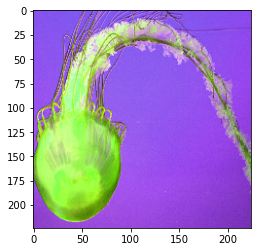

In [16]:
# plot transformer_try
plt.imshow(transformer_try(image = x_train[0])['image'])

In [17]:
def transformed_ds_try(img_ds):
    num = len(img_ds)
    transform_img_ds = []
    
    for i in range(num):
        img_dic = transformer_try(image = img_ds[i])
        transform_img_ds.append(img_dic['image'])
        
    return np.array(transform_img_ds)

## Create transformed training data & Concatenate those data

In [18]:
def transformed_ds(img_ds, transformer):
    num = len(img_ds)
    transform_img_ds = []
    
    for i in range(num):
        img_dic = transformer(image = img_ds[i])
        transform_img_ds.append(img_dic['image'])
        
    return np.array(transform_img_ds)

In [19]:
def create_transformed_data(x_train, y_train, transformer_list, num_data_apply_list):
    x_trans_list = []
    y_trans_list = []
    
    for i in range(len(transformer_list)):
        x_trans_list.append(transformed_ds(x_train, transformer_list[i])[ : num_data_apply_list[i]])
        y_trans_list.append(y_train[ : num_data_apply_list[i]])
        
#     for transformer in transformer_list:
#         x_trans.append(transformed_ds(x_train, transformer))
#         y_trans = np.concatenate((y_train , y_train))
    
    return np.array(np.concatenate(x_trans_list)), np.array(np.concatenate(y_trans_list))

In [20]:
# combined_1
# transformer_list = [transformer1, transformer7, transformer7, transformer11, transformer12, transformer5]
# num_data_apply_list = [len(x_train), len(x_train), len(x_train)//2, len(x_train), len(x_train), len(x_train)//2]

# combined_2
# transformer_list = [transformer1, transformer7]
# num_data_apply_list = [len(x_train), len(x_train)]

# combined_3
# transformer_list = [transformer7_11]
# num_data_apply_list = [len(x_train)]

# combined_4
# transformer_list = [transformer_try]
# num_data_apply_list = [len(x_train)]

# combined_5
transformer_list = [transformer5_7]
num_data_apply_list = [len(x_train)]

x_train_trans, y_train_trans = create_transformed_data(x_train, y_train, transformer_list, num_data_apply_list)

In [21]:
print(x_train_trans.shape)
print(y_train_trans.shape)

(2220, 224, 224, 3)
(2220, 2)


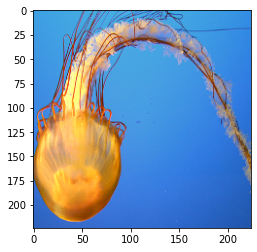

In [22]:
plt.imshow(x_train[0])

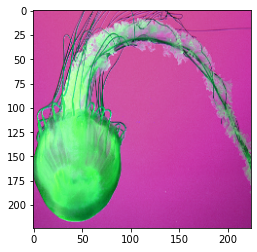

In [23]:
# plot transformer_try
plt.imshow(x_train_trans[0])

In [24]:
def transformed_ds1(img_ds):
    num = len(img_ds)
    transform_img_ds = []
    
    for i in range(num):
        img_dic = transformer1(image = img_ds[i])
        transform_img_ds.append(img_dic['image'])
        
    return np.array(transform_img_ds)

In [25]:
#print(transformed_ds1(x_train).shape)

In [26]:
# # check the result:

# x_train_trans4 = transformed_ds4(x_train)
# x_train_trans3 = transformed_ds3(x_train)
# #print(type(x_train_trans))
# print(x_train_trans4.shape)
# print(x_train.shape)

In [27]:
# # try

# x_train_trans_try = transformed_ds_try(x_train)
# x_train_trans = x_train_trans_try

In [28]:
# x_train_trans = np.concatenate((x_train_trans4 , x_train3))
# y_train = np.concatenate((y_train , y_train))

In [29]:
# model.load_weights(MODEL_PATH)

In [30]:
#model.load_weights('imagenet_Densenet121_combined6_acc=96.hdf5')

In [31]:
print(MODEL_PATH)

imagenet_Densenet121_current.hdf5


In [32]:
# with open('ChannelShuffle_data.npy', 'wb') as f:
#     np.save(f, x_train_trans)

### Define ta's loss and optimizer

In [33]:
# ''' from ta's code: https://github.com/lionelmessi641BATCH_SIZEntga/blob/main/evaluate.py '''

# lr_schedule = 1e-1
# step_per_epoch = int(len(x_train_trans)/BATCH_SIZE)

# learning_rate_fn = tf.keras.experimental.CosineDecay(lr_schedule, (EPOCHS*step_per_epoch))
# #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9, nesterov=False, name='SGD')
# loss_fn = tf.losses.CategoricalCrossentropy(from_logits=False) ##
# model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

## Start Training

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,  
                                             samplewise_center=False, 
                                             featurewise_std_normalization=False, 
                                             samplewise_std_normalization=False, 
                                             zca_whitening=False, ## val只有0.1
                                             zca_epsilon=1e-06, 
                                             rotation_range=0.0, 
                                             width_shift_range=0.0, ## 0.2
                                             height_shift_range=0.0, ## 0.1
                                             brightness_range=None, ## 不要用，很爛
                                             shear_range=0.0, 
                                             zoom_range=0.0, 
                                             channel_shift_range=0.0, 
                                             fill_mode='nearest', 
                                             cval=0.0, 
                                             horizontal_flip=False, 
                                             vertical_flip=False, ## 不要用，非常糟
                                             rescale=None, 
                                             preprocessing_function=None, 
                                             data_format=None, 
                                             validation_split=0.0, 
                                             dtype=None)

# datagen = ImageDataGenerator(
#     rotation_range=0,
#     width_shift_range=0.0,
#     height_shift_range=0.0)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train_trans, augment=True, rounds=2, seed=None)

# fits the model on batches with real-time data augmentation:
#show_augmented_result_dir = './ImageDataGenerator_result'

history = model.fit(datagen.flow(x_train_trans, y_train_trans, batch_size=BATCH_SIZE, shuffle=True),  shuffle=True,
                              steps_per_epoch=len(x_train_trans)/BATCH_SIZE, epochs=EPOCHS,
                              validation_data=(x_val, y_val),validation_steps=len(x_val)/BATCH_SIZE,
                              callbacks=callbacks_list)

''' baseline of x_train: 0.5/0.27[1] ~ 0.94/0.33[4] '''
'''
0.（不能用，因為value是float）FancyPCA (alpha=0.1, always_apply=False, p=0.5): X

1. (效果超好！)A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), 
val_shift_limit=(-40./255, -40./255), always_apply=False, p=1)
: 0.41/0.15[1] -> 0.86/0.60[7] -> 0.99/0.66[31]

2. (還行)A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)
: 0.28/0.29[1] -> 0.85/0.38[7] -> 0.95/0.40[10]

3. (bad)A.Downscale (scale_min=0.1, scale_max=0.1, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1)
: 0.47/0.24[1] -> 0.94/0.18[4]

4. (bad)A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1)
: 0.49/0.23 -> 0.95/0.25[4]

5. (還不錯)A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
: 0.41/0.27[1] -> 0.89/0.46[6]

6. (bad)A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
: 0.49/0.26[1] -> 0.93/0.26[4]

7. (超棒！)A.ChannelShuffle(p=1.0)
: 0.38/0.24[1] -> 0.84/0.59[8] -> 1.0/0.72[50?]
(有把training data存下來了('channelShuffle_data.npy')，因為怕是random channelShuffle剛好有不錯的結果)(QQ被我自己洗掉了)

8.（普通）A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
: 0.44/0.25[1] -> 0.92/0.37[6] -> 0.95/0.32[10]

9. (沒用)HorizontalFlip(p=0.1)
: 0.50/0.27[1] -> 0.92/0.29[3]
實驗證明，flip在這個task根本沒有幫助

10.（普通）A.RGBShift (r_shift_limit=(-40./255, 40./255), g_shift_limit=(-40./255, 40./255), b_shift_limit=(-40./255, 40./255), always_apply=False, p=1.0)
: 0.9/0.37[6]
跟shift的value有關

11. (不錯呦！)A.ToGray(p=1.0)
: 0.39/0.29[1] -> 0.86/0.55[8]

12. (不錯呦！)A.ToSepia (always_apply=False, p=1.0)
: 0.39/0.18[1] -> 0.79/0.52[6] -> 0.96/0.57[11]
train epochs要多點, lr小點，太大會overshoot

13. (bad)A.Superpixels (p_replace=0.1, n_segments=100, max_size=32, interpolation=1, always_apply=False, p=1.0)
: 0.53/0.21[1] -> 0.97/0.29[9]

# combined result:

1. ((1, 7, 7, 11, 12), (5)), with data比例(1: 1: 0.5: 1: 1: 0.5)
: 1.00/0.7374[68]
和7.沒什麼差

2. (1, 7) with (1: 1)
: 0.99/0.70[13]

3. (1.+7.)
: 0.97/0.68[16]

4. (7., 7.) with (1: 1)
: 1.00/0.72[33]

-------------------以上為cifar10的試驗，以下為imagenet的試驗-----------------------------
5. （很棒！）(5.+7.) 
: 0.54/0.53[1] -> 0.94/0.55[9] -> 0.97/0.96[20]
- leraning rate 從5e-4開始，從0.55一直改善到0.96
- 用ReduceLROnPlateau的training strategy可以在acc高的時候，依舊能改善acc而不一直overshoot

6. （考慮用(1.+7.)看看，因為在cifar10裡面不錯）
:

7. (5.+7.) + preprocessing layers
: 



'''


Epoch 1/35
69/69 [==============================] - 40s 405ms/step - loss: 0.4863 - acc: 0.8032 - val_loss: 0.9031 - val_acc: 0.5421

Epoch 00001: val_acc improved from -inf to 0.54211, saving model to imagenet_Densenet121_current.hdf5
Epoch 2/35
69/69 [==============================] - 24s 346ms/step - loss: 0.3266 - acc: 0.8770 - val_loss: 3.0802 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.54211
Epoch 3/35
69/69 [==============================] - 24s 346ms/step - loss: 0.3007 - acc: 0.8770 - val_loss: 0.7176 - val_acc: 0.6763

Epoch 00003: val_acc improved from 0.54211 to 0.67632, saving model to imagenet_Densenet121_current.hdf5
Epoch 4/35
69/69 [==============================] - 24s 350ms/step - loss: 0.2477 - acc: 0.9018 - val_loss: 0.3038 - val_acc: 0.9000

Epoch 00004: val_acc improved from 0.67632 to 0.90000, saving model to imagenet_Densenet121_current.hdf5
Epoch 5/35
69/69 [==============================] - 24s 348ms/step - loss: 0.2342 - acc: 0.9113 - val_

"\n0.（不能用，因為value是float）FancyPCA (alpha=0.1, always_apply=False, p=0.5): X\n\n1. (效果超好！)A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), \nval_shift_limit=(-40./255, -40./255), always_apply=False, p=1)\n: 0.41/0.15[1] -> 0.86/0.60[7] -> 0.99/0.66[31]\n\n2. (還行)A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)\n: 0.28/0.29[1] -> 0.85/0.38[7] -> 0.95/0.40[10]\n\n3. (bad)A.Downscale (scale_min=0.1, scale_max=0.1, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1)\n: 0.47/0.24[1] -> 0.94/0.18[4]\n\n4. (bad)A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1)\n: 0.49/0.23 -> 0.95/0.25[4]\n\n5. (還不錯)A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)\n: 0.41/0.27[1] -> 0.89/0.46[6]\n\n6. (bad)A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)\n: 0.49/0.26[1] -> 0.93/0.26[4]

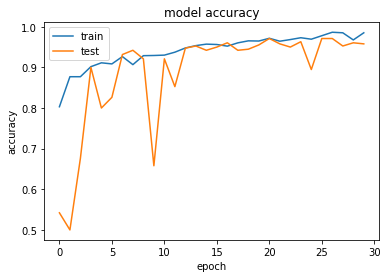

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./densenet121_try5_current', dpi='figure')
plt.show()

## Testing data output

In [36]:
model.load_weights(MODEL_PATH)

In [40]:
x_test = np.load('./dataset/x_test_imagenet.npy')

In [41]:
y_test = np.argmax(model.predict(x_test, batch_size=BATCH_SIZE, verbose=1), axis=1).tolist()

4/4 [==============================] - 2s 286ms/step


In [43]:
id_csv = [i for i in range(len(y_test))]
df = pd.DataFrame(list(zip(id_csv,y_test)), columns = ['id','label'])
df.to_csv('./imagenet_densenet121_current.csv', index=False)

#### 